In [1]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import numpy as np

# Following this tutorial: https://learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/
# and following this tutorial: https://pytorch.org/blog/torchvision03/

# Trying Semantic Segmentation

In [2]:
# Load pretrained segmentation network
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

# Input dimensions:
# Ni -> the batch size
# Ci -> the number of channels (which is 3)
# Hi -> the height of the image
# Wi -> the width of the image

# Output dimensions:
# No -> is the batch size (same as Ni)
# Co -> is the number of classes that the dataset have!
# Ho -> the height of the image (which is the same as Hi in almost all cases)
# Wo -> the width of the image (which is the same as Wi in almost all cases)

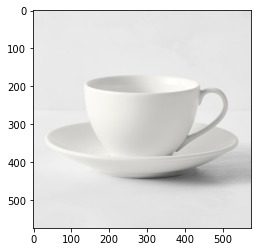

In [3]:
# Load image to be segmented
img = Image.open('teacup.jpg')
plt.imshow(img)
plt.show()

In [4]:
# Pre-process image so that it can be fed into the network
trf = T.Compose([T.Resize(256), # resize image so that it is 256x256
                 T.CenterCrop(224), # center crop image to 224x224
                 T.ToTensor(), # convert image to a tensor (all values between 0 and 1)
                 T.Normalize(mean = [0.485, 0.456, 0.406], # normalize with Imagenet specific values
                             std = [0.229, 0.224, 0.225])
                ])

inp = trf(img).unsqueeze(0) # Unsqueeze to [1 x C x H x W] from [C x H x W]

In [5]:
# Pass the input through the net
out = fcn(inp)['out']
print(out.shape)

# Note that there are 21 classes (index 1 of the output) 

torch.Size([1, 21, 224, 224])


In [6]:
# We need to convert the 21 channeled output into a 1 channel image.
# The argmax along the 2nd axis of each pixel will be the classification

om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)

(224, 224)


In [7]:
# There are two labels for all the pixels in the image
print (np.unique(om))

[ 0 11]


In [8]:
# Define the helper function
def decode_segmap(image, nc=21):
    """
        converts 2D image to an RGB image where each label is mapped to its corresponding color
    """
    label_colors = np.array([(0, 0, 0),  # 0=background
    # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
    (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
    # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
    (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
    # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
    (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
    # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
    (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

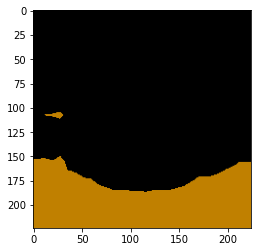

In [9]:
# Display labeled image
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()


# Haha didn't work very well -- teacup is not a class so it was not identified 

In [10]:
# Putting it all into one function
def segment(net, path):
    img = Image.open(path)
    plt.imshow(img); plt.axis('off'); plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(256),
                     T.CenterCrop(224),
                     T.ToTensor(),
                     T.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])
                    ])
    inp = trf(img).unsqueeze(0)
    out = net(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    plt.imshow(rgb); plt.axis('off'); plt.show()

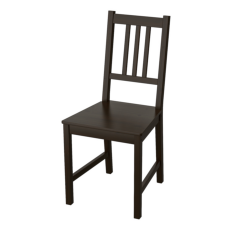

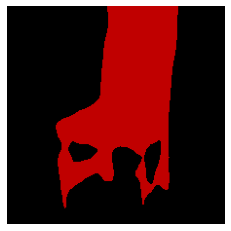

In [15]:
segment(fcn, 'chair.jpg')

# Trying out Mask R-CNN for Object Detection

In [48]:
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()

image = Image.open('teacup.jpg')
image_tensor = T.functional.to_tensor(image)

# pass a list of (potentially different sized) tensors
# to the model, in 0-1 range. The model will take care of
# batching them together and normalizing
output = model([image_tensor])
# output is a list of dict, containing the postprocessed predictions

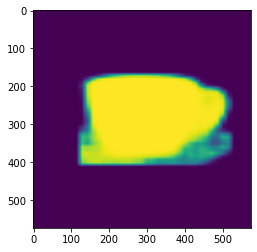

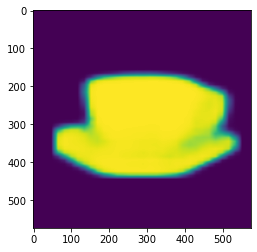

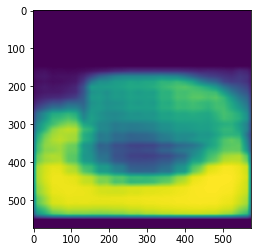

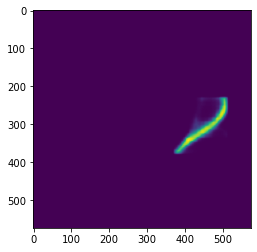

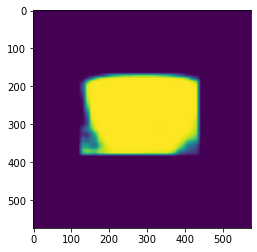

In [49]:
masks = output[0]['masks'].detach().numpy()

for mask in masks:
    plt.imshow(mask[0]); plt.show()

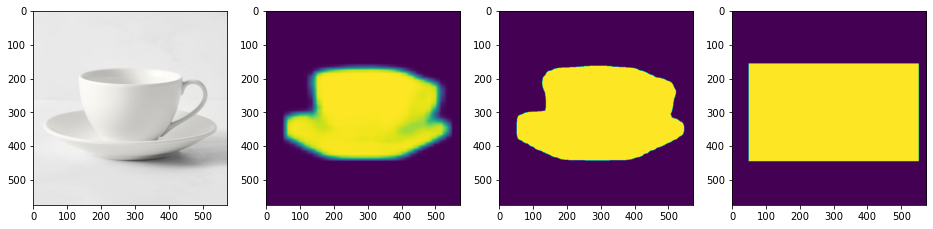

In [50]:
new_mask = np.where(masks[1][0] > .2, 1, 0)
full_mask = np.where(masks[1][0] > 0, 1, 0)

fig, axs = plt.subplots(1,4, figsize=(16,8))
axs[3].imshow(full_mask)
axs[2].imshow(new_mask)
axs[1].imshow(masks[1][0])
axs[0].imshow(image)
plt.show()

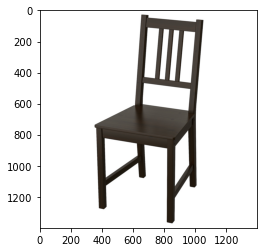

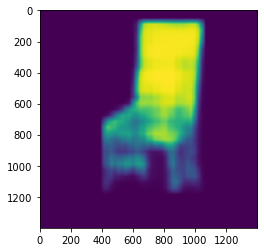

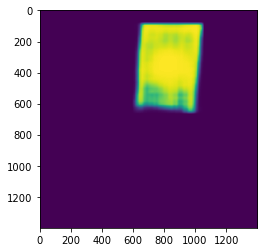

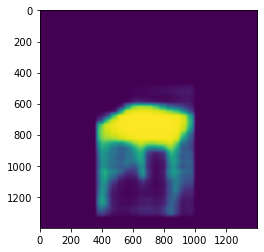

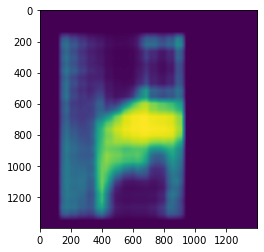

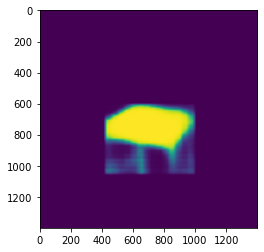

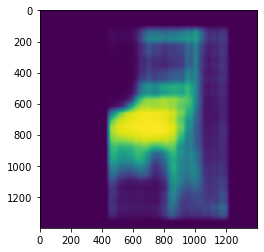

In [16]:
image = Image.open('chair.jpg')
image_tensor = T.functional.to_tensor(image)
plt.imshow(image); plt.show()

output = model([image_tensor])
masks = output[0]['masks'].detach().numpy()

for mask in masks:
    plt.imshow(mask[0]); plt.show()



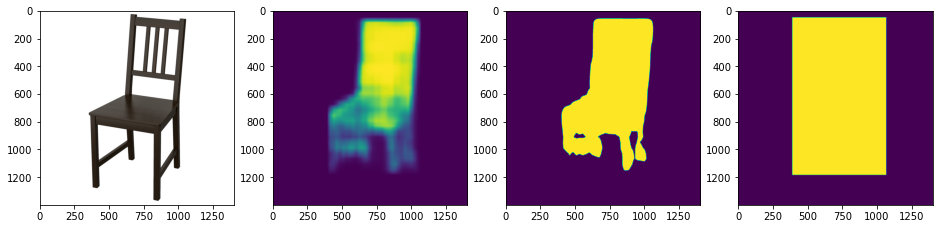

In [47]:
new_mask = np.where(masks[0][0] > .2, 1, 0)
full_mask = np.where(masks[0][0] > 0, 1, 0)

fig, axs = plt.subplots(1,4, figsize=(16,8))
axs[3].imshow(full_mask)
axs[2].imshow(new_mask)
axs[1].imshow(masks[0][0])
axs[0].imshow(image)
plt.show()

# Neural Style Transfer
 
Following [Neural Transfer Using Pytorch](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) tutorial

In [51]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading Images

In [54]:
# Loading images

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize+20),  # scale imported image
    T.CenterCrop(imsize), # center crop image to 224x224
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    
    return image.to(device, torch.float)


style_img = image_loader("fur.jpg")
content_img = image_loader("teacup.jpg")


assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

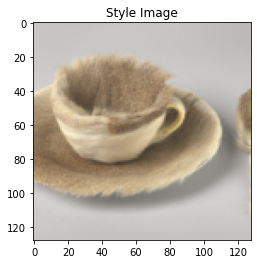

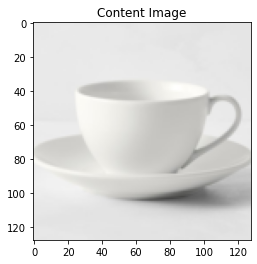

In [133]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

def imsave(tensor, filename):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    image.save(filename)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001) # pause a bit so that plots are updated

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

### Loss Functions

In [56]:
# Content Loss

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [57]:
# Style Loss

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

### Importing the Model

In [58]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/georgiapope/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [59]:
# Preparing images to be fed into model

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [60]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

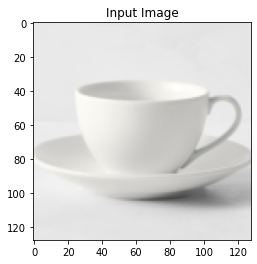

In [61]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [62]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [63]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

## Fur 1

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


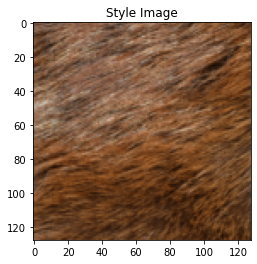

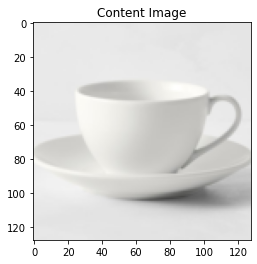

In [263]:
style_img = image_loader("fur.jpg")[:,:3]
content_img = image_loader("teacup.jpg")[:,:3]

print(style_img.size())
print(content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Building the style transfer model..


/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 215.872910 Content Loss: 21.815998

run [100]:
Style Loss : 76.712845 Content Loss: 21.239460

run [150]:
Style Loss : 29.710432 Content Loss: 21.044634

run [200]:
Style Loss : 13.898043 Content Loss: 20.636913

run [250]:
Style Loss : 7.897363 Content Loss: 19.810011

run [300]:
Style Loss : 4.654890 Content Loss: 19.065044



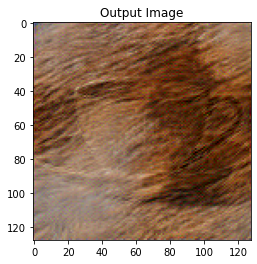

In [264]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

imsave(output, "fur_transfer.png")
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

## Fur 2

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


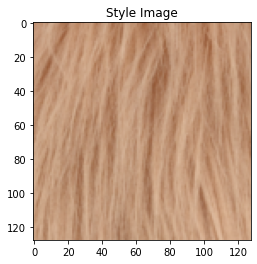

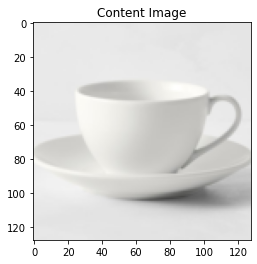

In [136]:
style_img = image_loader("fur2.jpg")[:,:3]
content_img = image_loader("teacup.jpg")[:,:3]

print(style_img.size())
print(content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Building the style transfer model..


/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 68.063728 Content Loss: 12.248793

run [100]:
Style Loss : 20.380951 Content Loss: 12.210699

run [150]:
Style Loss : 6.510810 Content Loss: 11.874423

run [200]:
Style Loss : 2.578387 Content Loss: 11.452208

run [250]:
Style Loss : 1.228600 Content Loss: 10.930620

run [300]:
Style Loss : 0.864499 Content Loss: 10.549318



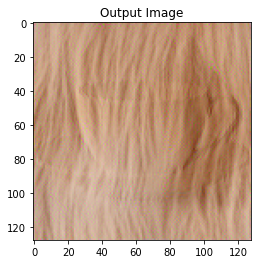

In [137]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

imsave(output, "fur2_transfer.png")
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

## Fur 3

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


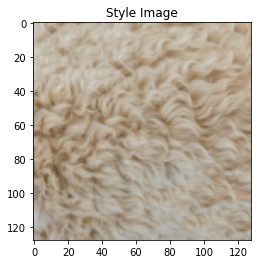

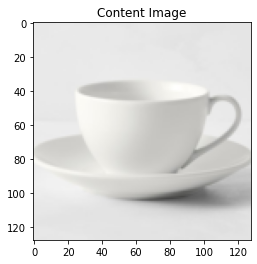

In [138]:
style_img = image_loader("fur3.jpg")[:,:3]
content_img = image_loader("teacup.jpg")[:,:3]

print(style_img.size())
print(content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Building the style transfer model..


/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 24.256592 Content Loss: 14.470205

run [100]:
Style Loss : 3.942535 Content Loss: 13.645094

run [150]:
Style Loss : 2.382145 Content Loss: 12.762920

run [200]:
Style Loss : 1.613191 Content Loss: 12.206299

run [250]:
Style Loss : 1.147815 Content Loss: 11.882723

run [300]:
Style Loss : 0.963753 Content Loss: 11.630115



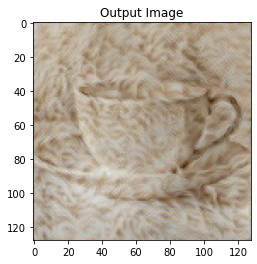

In [139]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

imsave(output, "fur3_transfer.png")
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

## Fur 4

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


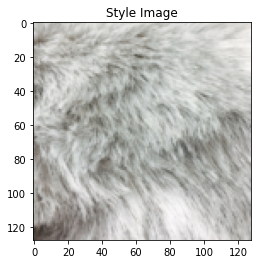

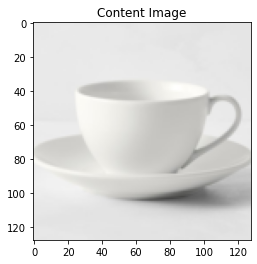

In [140]:
style_img = image_loader("fur4.jpg")[:,:3]
content_img = image_loader("teacup.jpg")[:,:3]

print(style_img.size())
print(content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Building the style transfer model..


/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 42.282906 Content Loss: 14.935673

run [100]:
Style Loss : 20.305494 Content Loss: 14.596823

run [150]:
Style Loss : 8.220947 Content Loss: 14.365046

run [200]:
Style Loss : 2.958190 Content Loss: 14.095463

run [250]:
Style Loss : 1.545760 Content Loss: 13.696183

run [300]:
Style Loss : 1.155484 Content Loss: 13.333475



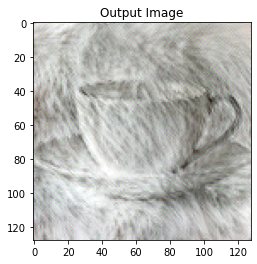

In [141]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
imsave(output, "fur4_transfer.png")
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

## Fur 5

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


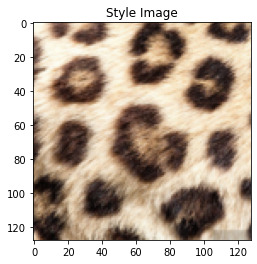

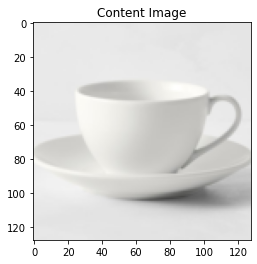

In [142]:
style_img = image_loader("fur5.jpg")[:,:3]
content_img = image_loader("teacup.jpg")[:,:3]

print(style_img.size())
print(content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Building the style transfer model..


/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 241.000488 Content Loss: 26.064911

run [100]:
Style Loss : 49.610485 Content Loss: 26.150600

run [150]:
Style Loss : 19.320381 Content Loss: 26.186630

run [200]:
Style Loss : 9.907185 Content Loss: 26.016668

run [250]:
Style Loss : 6.186877 Content Loss: 25.644802

run [300]:
Style Loss : 4.536586 Content Loss: 25.271326



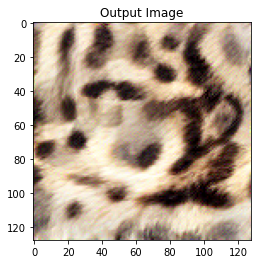

In [143]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

imsave(output, "fur5_transfer.png")
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

## Object

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


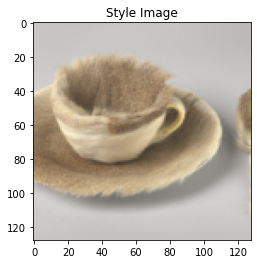

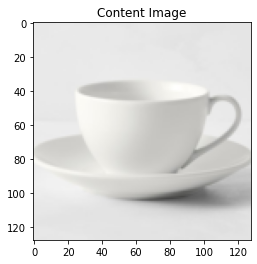

In [144]:
style_img = image_loader("object.jpg")[:,:3]
content_img = image_loader("teacup.jpg")[:,:3]

print(style_img.size())
print(content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Building the style transfer model..


/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 28.395451 Content Loss: 10.221516

run [100]:
Style Loss : 12.787736 Content Loss: 9.106397

run [150]:
Style Loss : 6.353267 Content Loss: 8.295996

run [200]:
Style Loss : 3.263230 Content Loss: 7.675551

run [250]:
Style Loss : 2.390602 Content Loss: 7.175804

run [300]:
Style Loss : 2.037994 Content Loss: 6.770616



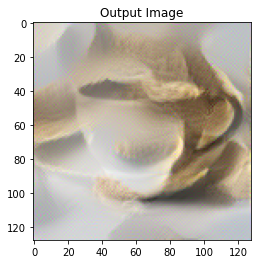

In [145]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

imsave(output, "object_transfer.png")
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()



# Combining everything

In [249]:
content_img = image_loader("teacup.jpg")[:,:3]
imsave(content_img, "small_teacup.jpg")

In [250]:
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()


image = Image.open('small_teacup.jpg')
image_tensor = T.functional.to_tensor(image)

# pass a list of (potentially different sized) tensors
# to the model, in 0-1 range. The model will take care of
# batching them together and normalizing
output = model([image_tensor])
# output is a list of dict, containing the postprocessed predictions

row:0
col:0
row:0
col:1
row:0
col:2
row:0
col:3
row:1
col:0
row:1
col:1
row:1
col:2
row:1
col:3


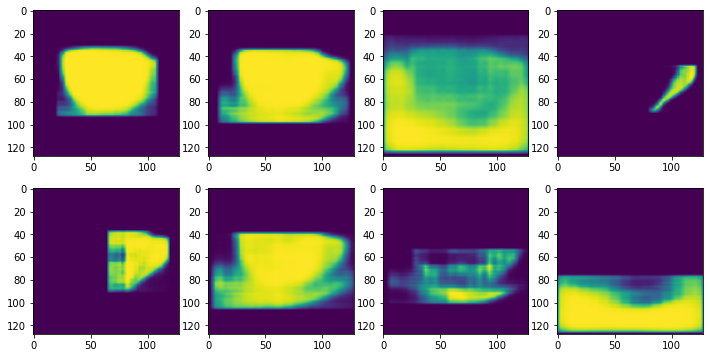

In [259]:
masks = output[0]['masks'].detach().numpy()
fig, axs = plt.subplots(2,4, figsize = (12,6))

i = 0
for row in [0,1]:
    for col in [0,1,2,3]:
        print(f'row:{row}')
        print(f'col:{col}')
        axs[row,col].imshow(masks[i][0])
        i+=1
        

In [258]:
masks[1][0].sum()

5656.728

In [267]:
best_mask = masks[5][0]
fur_image = cv2.imread("fur3_transfer.png", cv2.IMREAD_COLOR)
cup_image = cv2.imread("small_teacup.jpg", cv2.IMREAD_COLOR)
# image = cv2.imread("small_teacup.png", cv2.IMREAD_COlOR)

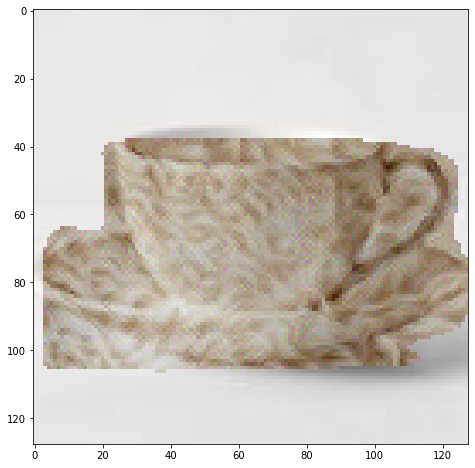

In [270]:
# Naive mask

naive_mask = np.where(best_mask > 0.1, True, False)
(rows, cols) = image.size
new_image = cup_image.copy()
# new_image_array = np.array(image)
# fur_image_array = np.array(fur_image)


for row in range(rows):
    for col in range(cols):
        if naive_mask[row,col]:
            new_image[row, col] = fur_image[row,col]
#         else:
#             new_image[row, col] = fur_image[row,col]
            
            
image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)            
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.imshow(image_rgb)

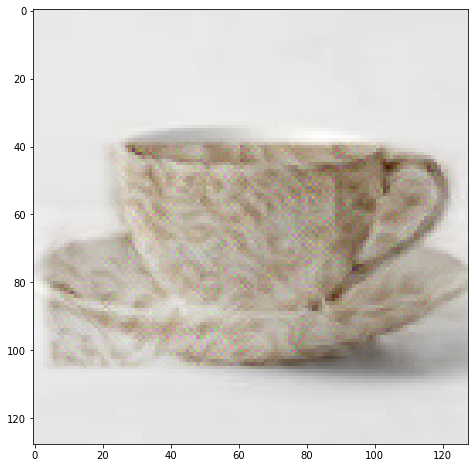

In [269]:
# Smarter Mask
new_image = cup_image.copy()

for row in range(rows):
    for col in range(cols):
        mask_val = best_mask[row,col]
        new_image[row, col] = fur_image[row,col]*mask_val + new_image[row,col]*(1-mask_val)
        
image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)            
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.imshow(image_rgb)


# Hairless cat

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


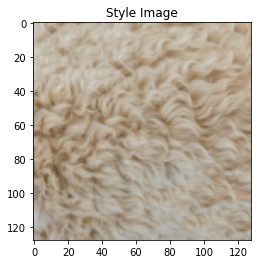

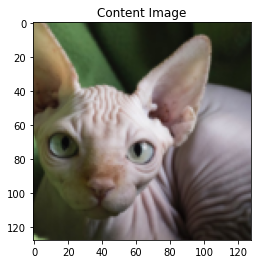

Building the style transfer model..


/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 33.739441 Content Loss: 26.867207

run [100]:
Style Loss : 7.269068 Content Loss: 22.087414

run [150]:
Style Loss : 4.324349 Content Loss: 17.915535

run [200]:
Style Loss : 3.341942 Content Loss: 14.809875

run [250]:
Style Loss : 2.643212 Content Loss: 12.866385

run [300]:
Style Loss : 2.157434 Content Loss: 11.517361



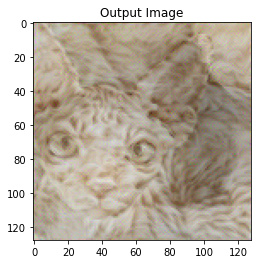

In [227]:
style_img = image_loader("fur3.jpg")[:,:3]
content_img = image_loader("hairless_cat.jpg")[:,:3]

print(style_img.size())
print(content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

imsave(output, "fur5_transfer.png")
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [228]:
content_img = image_loader("hairless_cat.jpg")[:,:3]
imsave(content_img, "small_hairless_cat.jpg")

In [229]:
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()


image = Image.open('small_hairless_cat.jpg')
image_tensor = T.functional.to_tensor(image)

# pass a list of (potentially different sized) tensors
# to the model, in 0-1 range. The model will take care of
# batching them together and normalizing
output = model([image_tensor])
# output is a list of dict, containing the postprocessed predictions

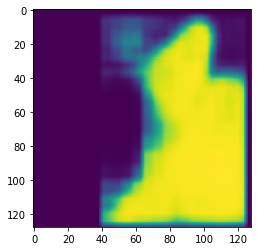

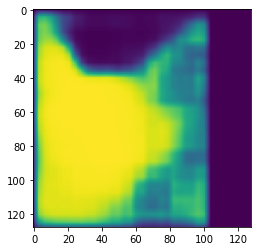

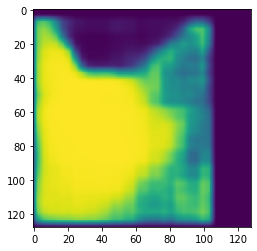

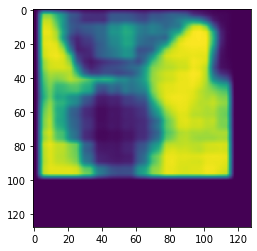

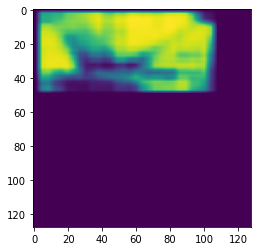

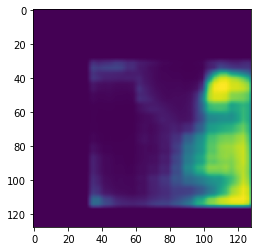

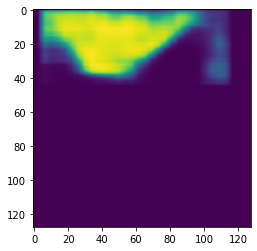

In [230]:
masks = output[0]['masks'].detach().numpy()

for mask in masks:
    plt.imshow(mask[0]); plt.show()

In [244]:
best_mask = np.maximum(masks[0][0], masks[1][0])
fur_image = cv2.imread("fur5_transfer.png", cv2.IMREAD_COLOR)
cat_image = cv2.imread("small_hairless_cat.jpg", cv2.IMREAD_COLOR)

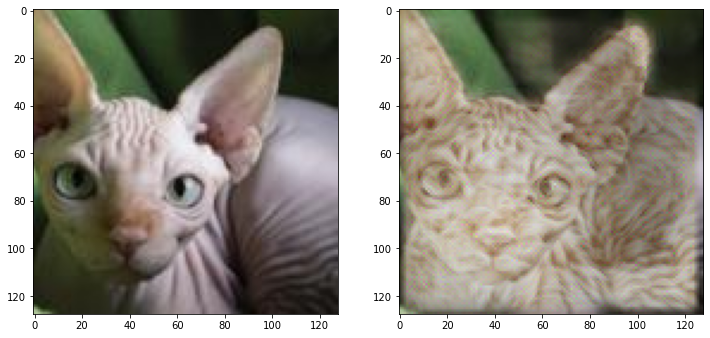

In [245]:
# Smarter Mask
new_image = cat_image.copy()

for row in range(rows):
    for col in range(cols):
        mask_val = best_mask[row,col]
        new_image[row, col] = fur_image[row,col]*mask_val + new_image[row,col]*(1-mask_val)
        
image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)  
cat_image_rgb = cv2.cvtColor(cat_image, cv2.COLOR_BGR2RGB) 
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[1].imshow(image_rgb)
ax[0].imshow(cat_image_rgb)

# Basketball


torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


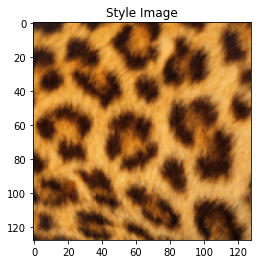

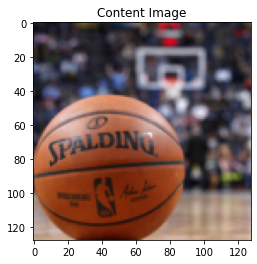

Building the style transfer model..


/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 179.812073 Content Loss: 57.279762

run [100]:
Style Loss : 27.043392 Content Loss: 53.626457

run [150]:
Style Loss : 9.931667 Content Loss: 48.349106

run [200]:
Style Loss : 6.386480 Content Loss: 43.578629

run [250]:
Style Loss : 5.075610 Content Loss: 40.103237

run [300]:
Style Loss : 4.409541 Content Loss: 37.261276



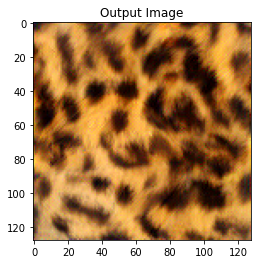

In [271]:
style_img = image_loader("cheetah.jpg")[:,:3]
content_img = image_loader("basketball.jpg")[:,:3]

print(style_img.size())
print(content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

imsave(output, "cheetah_basketball_transfer.png")
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [272]:
content_img = image_loader("basketball.jpg")[:,:3]
imsave(content_img, "small_basketball.jpg")

In [273]:
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()


image = Image.open('small_basketball.jpg')
image_tensor = T.functional.to_tensor(image)

# pass a list of (potentially different sized) tensors
# to the model, in 0-1 range. The model will take care of
# batching them together and normalizing
output = model([image_tensor])
# output is a list of dict, containing the postprocessed predictions

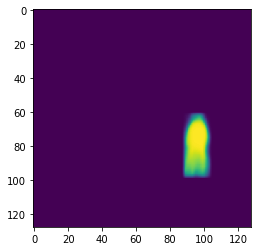

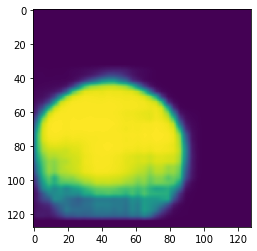

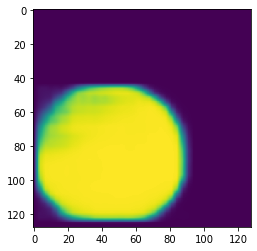

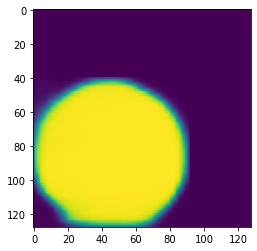

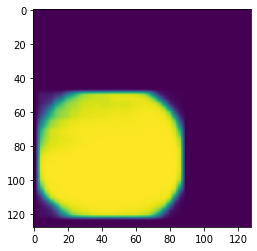

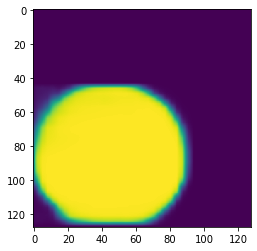

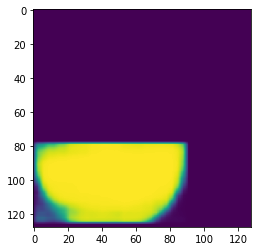

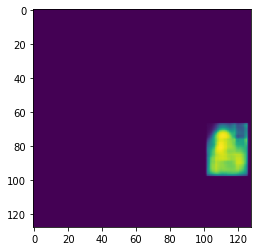

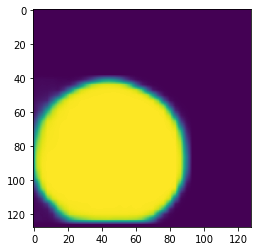

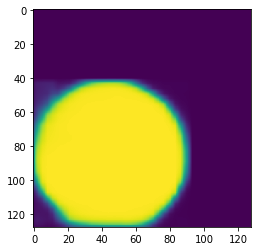

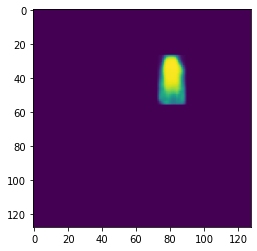

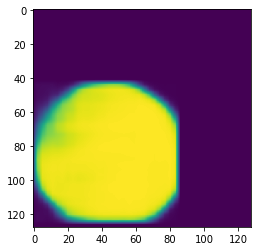

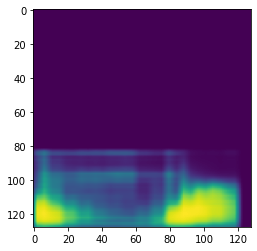

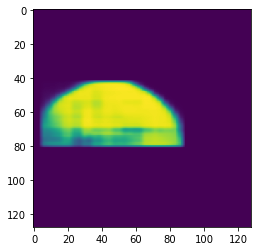

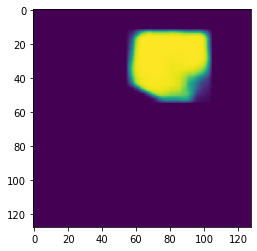

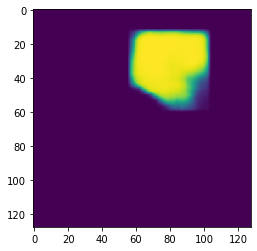

In [274]:
masks = output[0]['masks'].detach().numpy()

for mask in masks:
    plt.imshow(mask[0]); plt.show()

In [277]:
best_mask = np.maximum(masks[3
                            ][0], masks[1][0])
fur_image = cv2.imread("cheetah_basketball_transfer.png", cv2.IMREAD_COLOR)
cat_image = cv2.imread("small_basketball.jpg", cv2.IMREAD_COLOR)

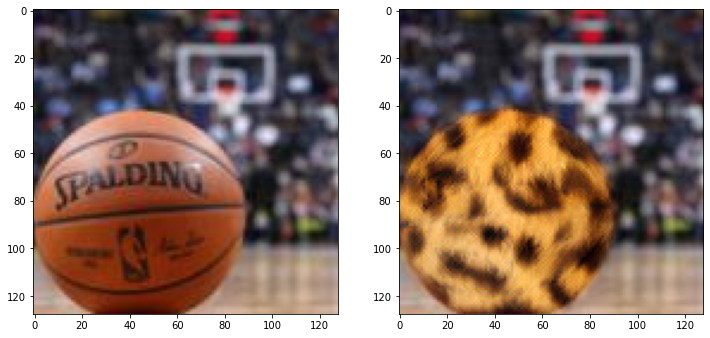

In [278]:
# Smarter Mask
new_image = cat_image.copy()

for row in range(rows):
    for col in range(cols):
        mask_val = best_mask[row,col]
        new_image[row, col] = fur_image[row,col]*mask_val + new_image[row,col]*(1-mask_val)
        
image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)  
cat_image_rgb = cv2.cvtColor(cat_image, cv2.COLOR_BGR2RGB) 
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[1].imshow(image_rgb)
ax[0].imshow(cat_image_rgb)

# Wally

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


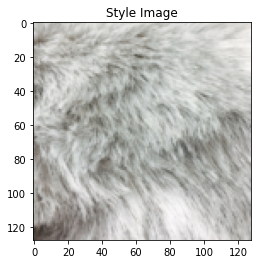

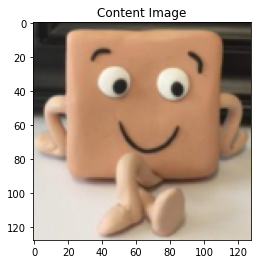

Building the style transfer model..


/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/georgiapope/anaconda/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 206.133438 Content Loss: 30.690731

run [100]:
Style Loss : 102.576797 Content Loss: 28.418312

run [150]:
Style Loss : 56.361946 Content Loss: 25.835052

run [200]:
Style Loss : 27.267149 Content Loss: 23.540966

run [250]:
Style Loss : 12.298550 Content Loss: 21.721687

run [300]:
Style Loss : 6.866249 Content Loss: 20.035192



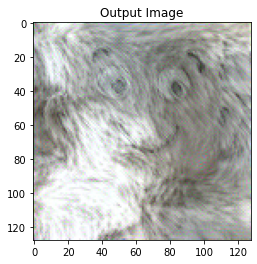

In [279]:
style_img = image_loader("fur4.jpg")[:,:3]
content_img = image_loader("wally.jpg")[:,:3]

print(style_img.size())
print(content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

imsave(output, "fur4_wally_transfer.png")
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

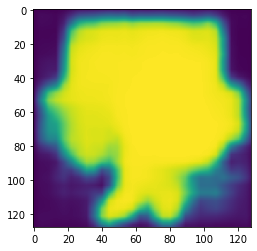

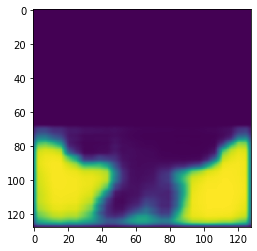

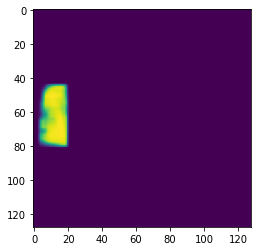

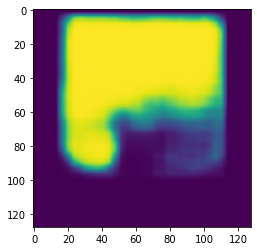

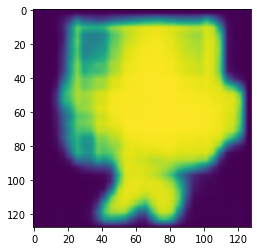

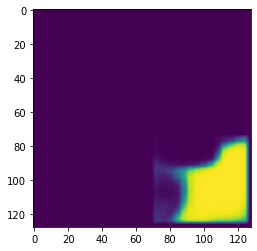

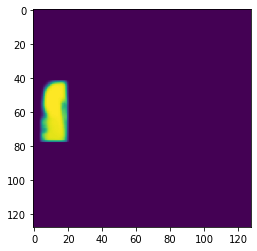

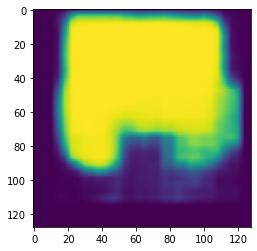

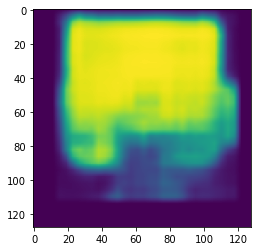

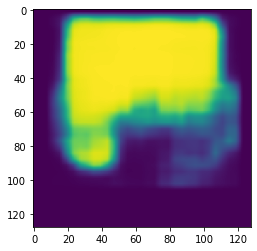

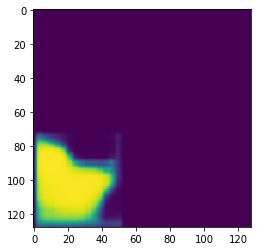

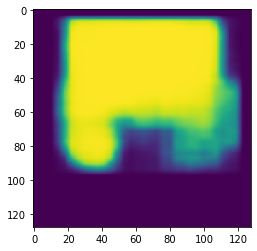

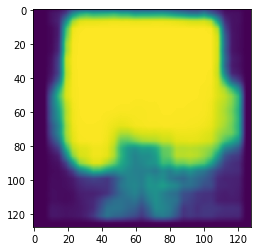

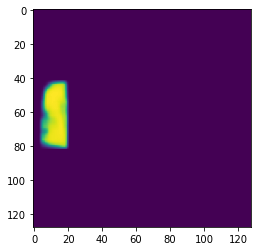

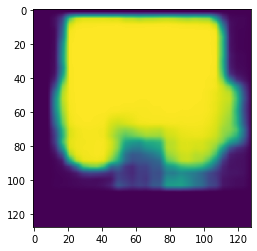

In [280]:
content_img = image_loader("wally.jpg")[:,:3]
imsave(content_img, "small_wally.jpg")

model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()


image = Image.open('small_wally.jpg')
image_tensor = T.functional.to_tensor(image)

# pass a list of (potentially different sized) tensors
# to the model, in 0-1 range. The model will take care of
# batching them together and normalizing
output = model([image_tensor])
# output is a list of dict, containing the postprocessed predictions

masks = output[0]['masks'].detach().numpy()

for mask in masks:
    plt.imshow(mask[0]); plt.show()

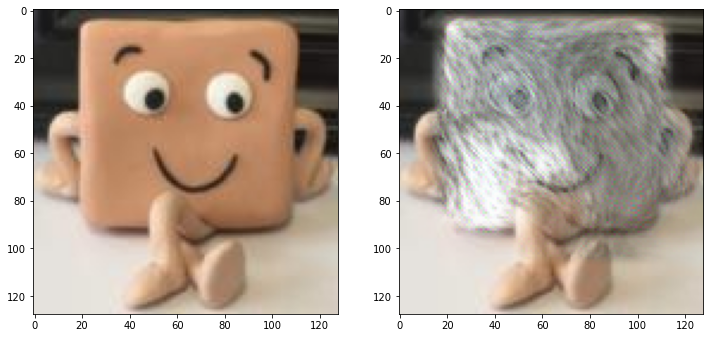

In [285]:
best_mask = masks[-1][0]
fur_image = cv2.imread("fur4_wally_transfer.png", cv2.IMREAD_COLOR)
cat_image = cv2.imread("small_wally.jpg", cv2.IMREAD_COLOR)

# Smarter Mask
new_image = cat_image.copy()

for row in range(rows):
    for col in range(cols):
        mask_val = best_mask[row,col]
        new_image[row, col] = fur_image[row,col]*mask_val + new_image[row,col]*(1-mask_val)
        
image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)  
cat_image_rgb = cv2.cvtColor(cat_image, cv2.COLOR_BGR2RGB) 
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[1].imshow(image_rgb)
ax[0].imshow(cat_image_rgb)

# Cup Again


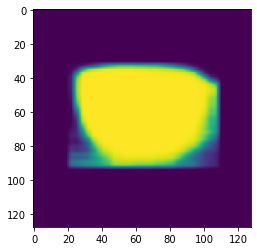

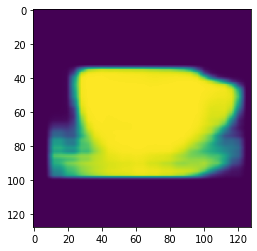

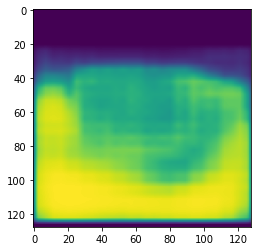

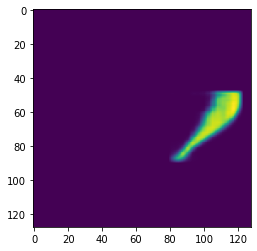

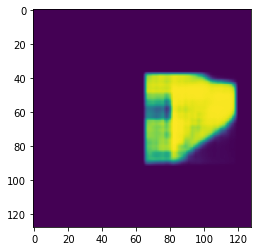

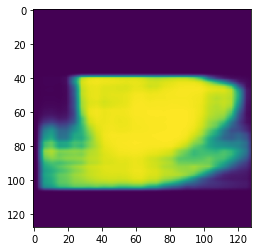

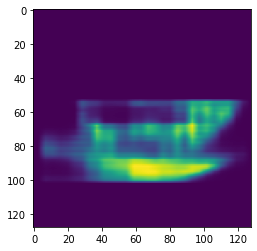

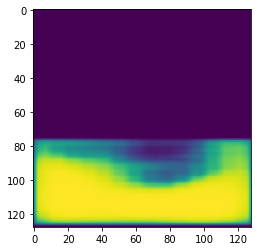

In [286]:


model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()


image = Image.open('small_teacup.jpg')
image_tensor = T.functional.to_tensor(image)

# pass a list of (potentially different sized) tensors
# to the model, in 0-1 range. The model will take care of
# batching them together and normalizing
output = model([image_tensor])
# output is a list of dict, containing the postprocessed predictions

masks = output[0]['masks'].detach().numpy()

for mask in masks:
    plt.imshow(mask[0]); plt.show()

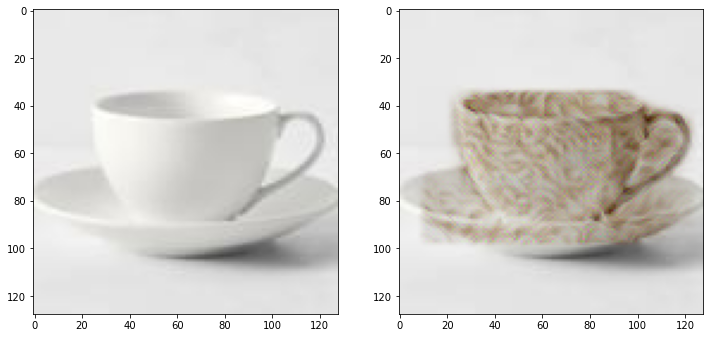

In [287]:
best_mask = masks[1][0]
fur_image = cv2.imread("fur3_transfer.png", cv2.IMREAD_COLOR)
cat_image = cv2.imread("small_teacup.jpg", cv2.IMREAD_COLOR)

# Smarter Mask
new_image = cat_image.copy()

for row in range(rows):
    for col in range(cols):
        mask_val = best_mask[row,col]
        new_image[row, col] = fur_image[row,col]*mask_val + new_image[row,col]*(1-mask_val)
        
image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)  
cat_image_rgb = cv2.cvtColor(cat_image, cv2.COLOR_BGR2RGB) 
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[1].imshow(image_rgb)
ax[0].imshow(cat_image_rgb)